In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Dataset paths
TRAIN_X_PATH = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset4\train_data.csv"
TRAIN_Y_PATH = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset4\train_label.csv"
TEST_X_PATH  = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset4\test_data.csv"
TEST_Y_PATH  = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset4\test_label.csv"

# Parameters
K_VALUES = [50, 75, 100]
ETA = 0.1           # smaller learning rate for stable training
CONV_THRESH = 0.001
MAX_EPOCHS = 50
np.random.seed(42)


In [31]:
X_train = pd.read_csv(TRAIN_X_PATH, header=None).values
y_train = pd.read_csv(TRAIN_Y_PATH, header=None).values.ravel().astype(int)
X_test  = pd.read_csv(TEST_X_PATH, header=None).values
y_test  = pd.read_csv(TEST_Y_PATH, header=None).values.ravel().astype(int)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num_classes = len(np.unique(y_train))
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Classes: {num_classes}")


Train shape: (2000, 36), Test shape: (500, 36), Classes: 5


In [32]:
def choose_sigma(centers):
    """Choose σ from mean inter-center distance."""
    d = cdist(centers, centers)
    d = d[np.triu_indices_from(d, k=1)]
    valid = d[d > 0]
    mean_dist = np.mean(valid) if valid.size else 1.0
    return mean_dist / np.sqrt(2)

def rbf_features(X, centers, sigma):
    """Compute Gaussian RBF activations."""
    dists = cdist(X, centers, metric="sqeuclidean")
    return np.exp(-dists / (2 * sigma**2))


RBF Network (Gaussian basis) | K = 50
Chosen σ: 3.98023
Converged after 50 epochs

Train Confusion Matrix:
[[296  33  15  26  30]
 [ 29 320  11  15  25]
 [ 47  30 207  64  52]
 [ 56  37  57 131 119]
 [ 32  15  45  41 267]]
Train Accuracy: 61.05%

Test Confusion Matrix:
[[69 11  5  8  7]
 [ 6 82  2  4  6]
 [12 12 46 19 11]
 [13 10 17 28 32]
 [ 6  9  6 11 68]]
Test Accuracy: 58.60%


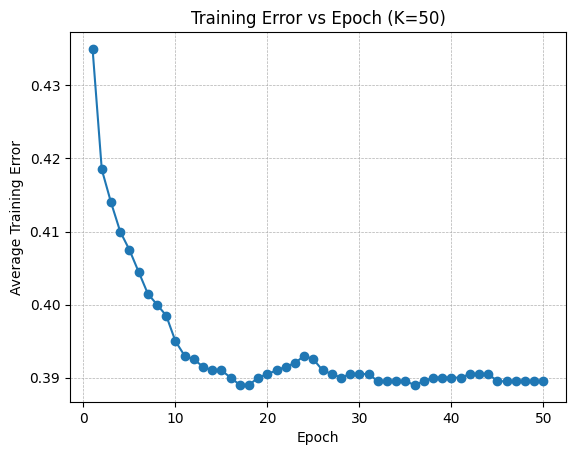

RBF Network (Gaussian basis) | K = 75
Chosen σ: 4.30786
Converged after 50 epochs

Train Confusion Matrix:
[[305  22  14  29  30]
 [ 30 313  11  27  19]
 [ 40  24 203  90  43]
 [ 53  29  39 183  96]
 [ 35  12  42  51 260]]
Train Accuracy: 63.20%

Test Confusion Matrix:
[[68 11  5 10  6]
 [ 7 78  2  5  8]
 [ 9  8 48 24 11]
 [16  8 17 29 30]
 [ 5  7  7 16 65]]
Test Accuracy: 57.60%


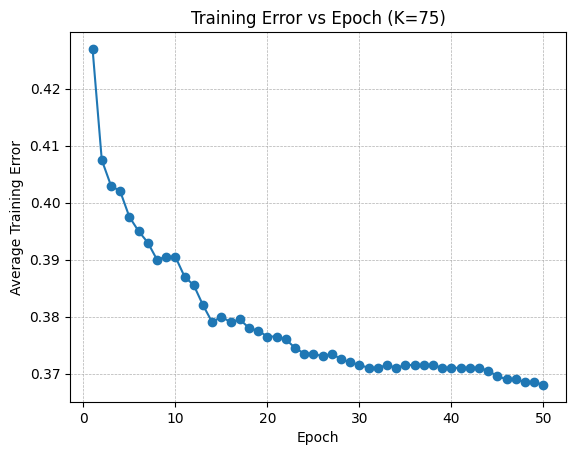

RBF Network (Gaussian basis) | K = 100
Chosen σ: 4.52618
Converged after 50 epochs

Train Confusion Matrix:
[[301  16  12  41  30]
 [ 27 309   9  31  24]
 [ 31  19 170 129  51]
 [ 39  24  28 205 104]
 [ 24  10  38  60 268]]
Train Accuracy: 62.65%

Test Confusion Matrix:
[[67 11  4 11  7]
 [ 6 80  1  6  7]
 [ 9  6 43 33  9]
 [16  7 11 39 27]
 [ 4  4  4 23 65]]
Test Accuracy: 58.80%


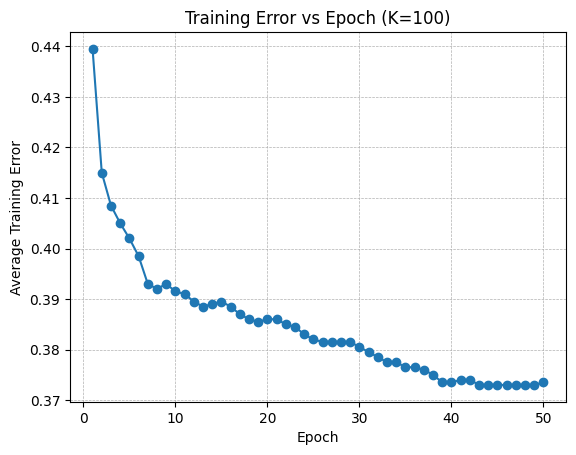

In [33]:
for K in K_VALUES:
    print("="*70)
    print(f"RBF Network (Gaussian basis) | K = {K}")
    print("="*70)

    # Step 1: K-means for centers
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_

    # Step 2: Choose σ
    sigma = choose_sigma(centers)
    print(f"Chosen σ: {sigma:.5f}")

    # Step 3: Build features
    Phi_train = rbf_features(X_train, centers, sigma)
    Phi_test  = rbf_features(X_test, centers, sigma)

    # Step 4: SGD training loop
    model = SGDClassifier(
        loss="log_loss",
        learning_rate="constant",
        eta0=ETA,
        max_iter=1,
        tol=None,
        random_state=42
    )

    prev_loss = np.inf
    losses = []

    for epoch in range(MAX_EPOCHS):
        model.partial_fit(Phi_train, y_train, classes=np.arange(num_classes))
        y_pred_train = model.predict(Phi_train)
        avg_err = np.mean(y_pred_train != y_train)
        losses.append(avg_err)
       
        prev_loss = avg_err

    print(f"Converged after {len(losses)} epochs")

    # Step 5: Evaluate
    y_pred_train = model.predict(Phi_train)
    y_pred_test = model.predict(Phi_test)

    print("\nTrain Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred_train))
    print("Train Accuracy:", f"{accuracy_score(y_train, y_pred_train)*100:.2f}%")

    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))
    print("Test Accuracy:", f"{accuracy_score(y_test, y_pred_test)*100:.2f}%")

    # Step 6: Training error vs epoch plot
    plt.figure()
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title(f"Training Error vs Epoch (K={K})")
    plt.xlabel("Epoch")
    plt.ylabel("Average Training Error")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()
